In [2]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.callbacks import LearningRateScheduler
from keras.optimizers import Adam

In [4]:
image_size = (180, 180)
batch_size = 128

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    "Data/PetImages",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Using 4682 files for validation.
Metal device set to: Apple M1 Max


In [5]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

In [6]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

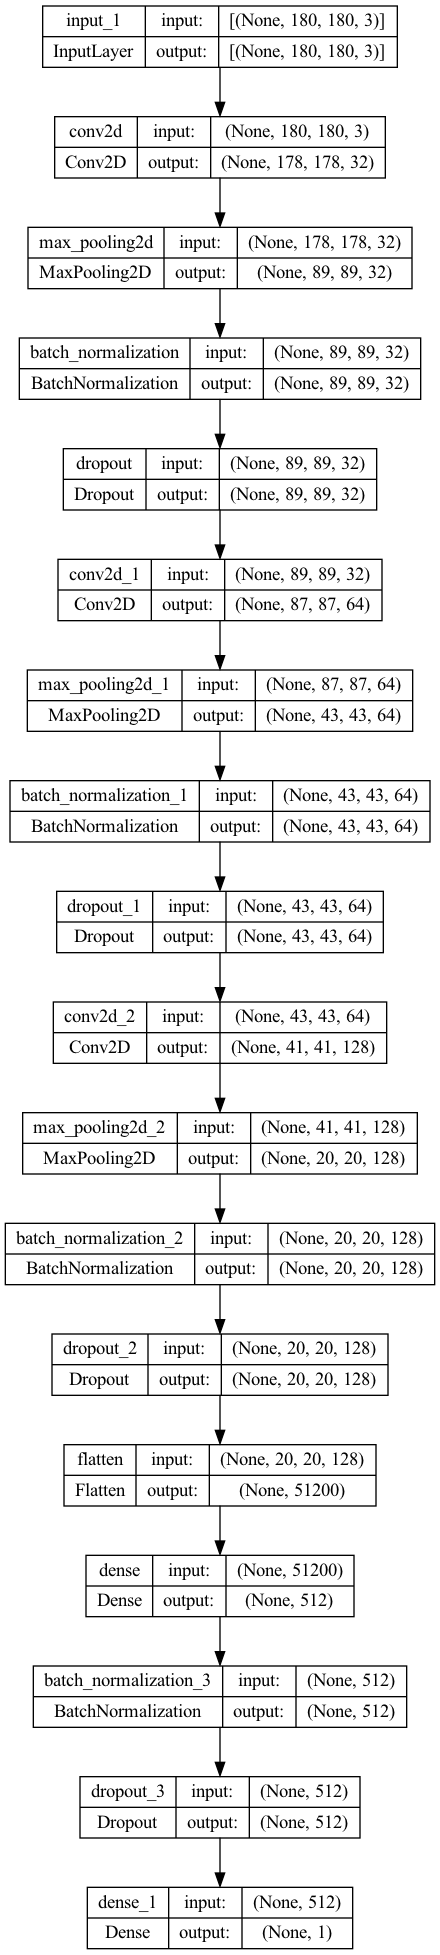

In [7]:
def create_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    x = (layers.Conv2D(32, (3, 3), activation='relu'))(inputs)
    x = (layers.MaxPooling2D((2, 2)))(x)
    x = (layers.BatchNormalization())(x)
    x = (layers.Dropout(0.25))(x)

    x = (layers.Conv2D(64, (3, 3), activation='relu'))(x)
    x = (layers.MaxPooling2D((2, 2)))(x)
    x = (layers.BatchNormalization())(x)
    x = (layers.Dropout(0.25))(x)

    x = (layers.Conv2D(128, (3, 3), activation='relu'))(x)
    x = (layers.MaxPooling2D((2, 2)))(x)
    x = (layers.BatchNormalization())(x)
    x = (layers.Dropout(0.25))(x)

    x = (layers.Flatten())(x)
    x = (layers.Dense(512, activation='relu'))(x)
    x = (layers.BatchNormalization())(x)
    x = (layers.Dropout(0.5))(x)

    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    outputs = (layers.Dense(units, activation=activation))(x)

    return keras.Model(inputs, outputs)

model_new = create_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model_new, show_shapes=True)

In [ ]:
epochs = 35

def schedule(epoch, learning_rate):
    if epoch < 10:
        return learning_rate
    else:
        return learning_rate * 0.1

# define your optimizer
optimizer = Adam(learning_rate=0.001)

# compile the model
model_new.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
    LearningRateScheduler(schedule, verbose=1)
]

model_new.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)